<a href="https://colab.research.google.com/github/blufzzz/two-stream-dyntex-synth/blob/spatio-temporal-statistics/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Here is experiments with approach described in 

http://arxiv.org/abs/1702.07006   


In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
cd ./gdrive/My\ Drive/Colab Notebooks/two-stream-dyntex-synth

/content/gdrive/My Drive/Colab Notebooks/two-stream-dyntex-synth


In [0]:
import os
import sys
import re
import skimage
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
import datetime
from scipy.optimize import minimize
import tensorflow as tf
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/two-stream-dyntex-synth/src') 
from utilities import load_image, load_images, vgg_process, vgg_deprocess, check_snapshots
from appearance_descriptor import AppearanceDescriptor
from optimizer import Optimizer

from IPython.core.debugger import set_trace

In [0]:
class Optimizer(object):

    def __init__(self, graph, input_dimension, input_frame_count,
                 target_dynamic_path, target_static_path, config):
        self.graph = graph
        self.input_dimension = input_dimension
        self.input_frame_count = input_frame_count
        self.target_dynamic_path = target_dynamic_path
        self.target_static_path = target_static_path
        self.user_config = config['user']
        self.tf_config = config['tf']

    def print_info(self, losses):
        i = self.iterations_so_far
        iterations = self.user_config['iterations']
        run_id = self.user_config['run_id']

        time_diff = time.time() - self.last_print
        it_per_sec = 1 / time_diff
        remaining_it = iterations - i
        eta = remaining_it / it_per_sec
        eta_string = str(datetime.timedelta(seconds=eta))

        print_string = '(%s) Iteration %d: dynamic texture loss: %f ' \
                       'iter per/s: %f ETA: %s' % (run_id, i + 1,losses[0],
                                                   it_per_sec, eta_string)
        print print_string
        self.last_print = time.time()

    def minimize_callback(self, dyntex_loss, output, summaries):
        # if hasattr(self, 'current_loss'):
        #     self.past_loss = self.current_loss
        # self.current_loss = dyntex_loss
        # for cleanliness
        i = self.iterations_so_far
        snapshot_frequency = self.user_config['snapshot_frequency']
        network_out_frequency = self.user_config['network_out_frequency']
        log_frequency = self.user_config['log_frequency']
        run_id = self.user_config['run_id']

        # print training information
        self.print_info([dyntex_loss])

#         if (i + 1) % snapshot_frequency == 0:
#             print 'Saving snapshot...'
#             try:
#                 os.makedirs('snapshots/' + run_id)
#             except OSError:
#                 if not os.path.isdir('snapshots/' + run_id):
#                     raise
#             self.saver.save(self.sess, 'snapshots/' + run_id + '/iter',
#                             global_step=i+1)
            
#         if (i + 1) % log_frequency == 0:
#             print 'Saving log file...'
#               self.summary_writer.add_summary(summaries, i + 1)
#               self.summary_writer.flush()

        if (i + 1) % network_out_frequency == 0:
    
            print 'Saving image(s)...'
            try:
                os.makedirs('data/out/' + run_id)
            except OSError:
                if not os.path.isdir('data/out/' + run_id):
                    raise
            network_out = output.reshape((self.input_dimension,
                                          self.input_dimension, 3))
            
            img_out = vgg_deprocess(network_out, no_clip=False,
                                    unit_scale=False)
            
            
            if os.listdir('data/out/' + run_id):

                last_number = int(sorted([re.findall('\d+',imname)[-1]
                                      for imname in os.listdir('data/out/' + run_id)])[-1])

            else:    

                last_number = 0

            filename = 'data/out/' + run_id + \
                '/iter_%d_frame_%d.png'

            skimage.io.imsave(filename %
                              (i + 1, last_number + 1), img_out)

        self.iterations_so_far += 1

    def step_callback(self, args):
        if hasattr(self, 'past_loss'):
            loss_diff = (self.past_loss - self.current_loss) / \
                np.amax([np.abs(self.past_loss), np.abs(self.current_loss), 1])
            print 'f diff = ' + str(loss_diff)

    def optimize(self):
        iterations = self.user_config['iterations']
        run_id = self.user_config['run_id']

        with self.graph.as_default():
            """
            Instantiate optimizer
            """
            with tf.device('/gpu:' + str(self.user_config['gpu'])):
              
                optimizer = tf.contrib.opt.ScipyOptimizerInterface(	
                    self.dyntex_loss, 
                    method='L-BFGS-B',
                    options={'maxfun': iterations,
                             'disp': True,
                             'ftol': 1e-5})

            """
            Train over iterations, printing loss at each one
            """
            self.saver = tf.train.Saver(max_to_keep=0, pad_step_number=16)
            with tf.Session(config=self.tf_config) as self.sess:

                # TODO: change snapshot and log folders to be in a single
                # location
                # check snapshots
                resume, self.iterations_so_far = check_snapshots(run_id)
				
                # start summary writer
                #self.summary_writer = tf.summary.FileWriter('logs/' + run_id,
                #                                           self.sess.graph)
                
                if resume:
                    self.saver.restore(self.sess, resume)
                else:
                    self.sess.run(tf.global_variables_initializer()) # ^C occurs here!
				
                # initialize start time
                self.last_print = time.time()

                # start train loop
                print '-------OPTIMIZING USING L-BFGS-B-------'
                # scipy optimizer needs a callback for printing iter info
                optimizer.minimize(self.sess,
                                   fetches=[self.dyntex_loss,
                                            self.output,
                                            self.summaries],
                                   loss_callback=self.minimize_callback)


In [0]:
class SpatialGramSynthesizer(Optimizer):
  
  def __init__(self, target_dynamic_path, generated_dynamic_path, dt, config):

    Optimizer.__init__(self, tf.Graph(), 256, 12, target_dynamic_path, '',config)
    
    self.dt = dt
    
    with self.graph.as_default():
      with tf.device('/gpu:' + str(self.user_config['gpu'])):

        imgs = load_images(target_dynamic_path,
                       size=(self.input_frame_count,
                             self.input_dimension,
                             self.input_dimension))
        
        self.target_dynamic_texture = [tf.to_float(
            tf.constant(img.reshape(1, self.input_dimension,
                                  self.input_dimension, 3)))
                                  for img in imgs]

        initial_noise = tf.random_normal([1,
                                          self.input_dimension,
                                          self.input_dimension, 3])

        # Variable we'll optimize!
        self.output = tf.Variable(initial_noise, name='output')
        
        try:
          
          is_generated = len(os.listdir(generated_dynamic_path))
        
        except OSError:
          
          is_generated = False
        
        if is_generated:
        
          gen_imgs = load_images(generated_dynamic_path,
                         size=(self.input_frame_count,
                               self.input_dimension,
                               self.input_dimension))
          
          generated_dynamic_texture = [tf.to_float(
            tf.constant(img.reshape(1, self.input_dimension,
                                  self.input_dimension, 3)))
                                  for img in gen_imgs]
          
        else:
          
          generated_dynamic_texture = []

        # starting from the last (dt-1) frames we'll optimize new one (output)
        self.output_within_timeframe = (self.target_dynamic_texture + generated_dynamic_texture)[-(self.dt-1):] + [self.output]
        
        print (len(self.output_within_timeframe))

        self.dyntex_loss = self.build_spatial_gram_descriptors('spatial_gram_descriptors', 1e9)
        
        self.attach_summaries('summaries')

  def build_spatial_gram_descriptors(self, name, weight):

    with tf.get_default_graph().name_scope(name):
        # TODO: make this user-definable
        loss_layers = ['pool1', 'pool2',
                       'pool3', 'pool4']

        activations = []
        activations_output = []
        for i in range(self.input_frame_count):
            # texture target is in RGB [0,1], but VGG
            # accepts BGR [0-mean,255-mean] mean subtracted
            input = vgg_process(self.target_dynamic_texture[i])

            a = AppearanceDescriptor('spatial_gram_descriptor_' + str(i+1), name, input)

            activations.append([a.activations_for_layer(l) for l in loss_layers])

        for i in range(self.dt):

            a_output = AppearanceDescriptor('spatial_gram_descriptor_out_' + str(i+1), name,
                                            vgg_process(self.output_within_timeframe[i]))

            activations_output.append([a_output.activations_for_layer(l) for l in loss_layers])

        Gl = [] # Spatial Grammians of the target 
        Ol = [] # Spatial Grammians of the output 

        for l in range(len(loss_layers)):

            # gramians for this layer within different time-windows i:i+dt
            Gl_dt = []

            for i in range(self.input_frame_count - self.dt):
                
              Gl_dt.append(self.compute_timewindow_gram_l(activations[i:i+self.dt], l))
                  
            Gl.append(tf.reduce_mean(tf.concat(Gl_dt, 0), 0))

            # we take [0] to get make (N x N) tensor instead of (1 x N x N)
            Ol.append(self.compute_timewindow_gram_l(activations_output,l)[0])

        spatial_gram_loss = tf.add_n([tf.reduce_sum(tf.square(tf.subtract(G,O))) for G,O in zip(Gl, Ol)])

    return tf.multiply(spatial_gram_loss, weight)


  def compute_timewindow_gram_l(self,activations, layer):
  
    '''
    Returns gram matrixes of activations (within time-window dt) for some layer
    '''

    # reshape activations

    shape = activations[0][layer].get_shape().as_list()

    # F with shape M_l x dt*N_l
    F = tf.concat([tf.reshape(act[layer], (shape[1]*shape[2], shape[3])) for act in activations], axis = -1)

    mult = tf.matmul(F,F,transpose_a = True)

    # make a tensor shape: 1 x N x N instead of N x N
    mult = tf.expand_dims(mult,0)

    normalize_scale = tf.div(1.0, (shape[1]*shape[2]))

    return tf.multiply(normalize_scale, mult)
  
  def attach_summaries(self, name):
    with tf.get_default_graph().name_scope(name):

        tf.summary.scalar('dynamic_texture_loss', self.dyntex_loss)
        self.summaries = tf.summary.merge_all()
        

In [0]:
config_proto = tf.ConfigProto()
config_proto.gpu_options.allow_growth = True
config_proto.allow_soft_placement = True
config_proto.log_device_placement = False
my_config = {}
my_config['batch_size'] = 1
my_config['iterations'] = 6000
my_config['snapshot_frequency'] = 1000
my_config['network_out_frequency'] = 100
my_config['log_frequency'] = 100
my_config['gpu'] = 0
my_config['run_id'] = "fur_gram"
my_config['dynamics_model'] = 'MSOEnet'
config = {'tf': config_proto, 'user': my_config}

In [92]:
target_dynamic_path = './data/dynamic_textures/fur'
generated_dynamic_path = './data/out/fur_gram'

s = SpatialGramSynthesizer(target_dynamic_path, generated_dynamic_path, 2, config)

2
attach_summaries


In [89]:
s.optimize()

No snapshots found, training from scratch
-------OPTIMIZING USING L-BFGS-B-------
(fur_gram) Iteration 1: dynamic texture loss: 30607367175405568.000000 iter per/s: 0.142973 ETA: 11:39:26.101170
(fur_gram) Iteration 2: dynamic texture loss: 30014144144998400.000000 iter per/s: 2.436267 ETA: 0:41:02.373826
(fur_gram) Iteration 3: dynamic texture loss: 27748834511683584.000000 iter per/s: 2.509939 ETA: 0:39:49.699422
(fur_gram) Iteration 4: dynamic texture loss: 20255675653292032.000000 iter per/s: 2.492386 ETA: 0:40:06.128278
(fur_gram) Iteration 5: dynamic texture loss: 6868191724699648.000000 iter per/s: 2.471876 ETA: 0:40:25.687971
(fur_gram) Iteration 6: dynamic texture loss: 2937839234842624.000000 iter per/s: 2.472921 ETA: 0:40:24.258598
(fur_gram) Iteration 7: dynamic texture loss: 1207411943669760.000000 iter per/s: 2.460297 ETA: 0:40:36.291510
(fur_gram) Iteration 8: dynamic texture loss: 552632368234496.000000 iter per/s: 2.433687 ETA: 0:41:02.518680
(fur_gram) Iteration 9: dy

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: data/out/fur_gram/iter_200_frame_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)


(fur_gram) Iteration 201: dynamic texture loss: 30392847433728.000000 iter per/s: 2.116210 ETA: 0:45:40.749407
(fur_gram) Iteration 202: dynamic texture loss: 30381141131264.000000 iter per/s: 2.390475 ETA: 0:40:25.877430
(fur_gram) Iteration 203: dynamic texture loss: 30369808121856.000000 iter per/s: 2.368242 ETA: 0:40:48.229188
(fur_gram) Iteration 204: dynamic texture loss: 30361495011328.000000 iter per/s: 2.365364 ETA: 0:40:50.785386
(fur_gram) Iteration 205: dynamic texture loss: 30348505251840.000000 iter per/s: 2.354515 ETA: 0:41:01.653912
(fur_gram) Iteration 206: dynamic texture loss: 30339145662464.000000 iter per/s: 2.406119 ETA: 0:40:08.442423
(fur_gram) Iteration 207: dynamic texture loss: 30329402294272.000000 iter per/s: 2.354704 ETA: 0:41:00.606940
(fur_gram) Iteration 208: dynamic texture loss: 30322232131584.000000 iter per/s: 2.364921 ETA: 0:40:49.552860
(fur_gram) Iteration 209: dynamic texture loss: 30313451356160.000000 iter per/s: 2.359944 ETA: 0:40:54.296036
(

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: data/out/fur_gram/iter_300_frame_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)


(fur_gram) Iteration 301: dynamic texture loss: 29723329560576.000000 iter per/s: 2.095623 ETA: 0:45:19.954562
(fur_gram) Iteration 302: dynamic texture loss: 29721133842432.000000 iter per/s: 2.360317 ETA: 0:40:14.506505
(fur_gram) Iteration 303: dynamic texture loss: 29717746941952.000000 iter per/s: 2.395071 ETA: 0:39:39.052318
(fur_gram) Iteration 304: dynamic texture loss: 29714540396544.000000 iter per/s: 2.327601 ETA: 0:40:47.584687
(fur_gram) Iteration 305: dynamic texture loss: 29709586923520.000000 iter per/s: 2.318781 ETA: 0:40:56.463013
(fur_gram) Iteration 306: dynamic texture loss: 29705730260992.000000 iter per/s: 2.347120 ETA: 0:40:26.377535
(fur_gram) Iteration 307: dynamic texture loss: 29702695682048.000000 iter per/s: 2.390996 ETA: 0:39:41.434525
(fur_gram) Iteration 308: dynamic texture loss: 29700302831616.000000 iter per/s: 2.353717 ETA: 0:40:18.727983
(fur_gram) Iteration 309: dynamic texture loss: 29696634912768.000000 iter per/s: 2.340820 ETA: 0:40:31.626921
(

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: data/out/fur_gram/iter_400_frame_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)


(fur_gram) Iteration 401: dynamic texture loss: 29495968923648.000000 iter per/s: 2.125738 ETA: 0:43:54.379387
(fur_gram) Iteration 402: dynamic texture loss: 29494771449856.000000 iter per/s: 2.369196 ETA: 0:39:23.248837
(fur_gram) Iteration 403: dynamic texture loss: 29493628502016.000000 iter per/s: 2.359152 ETA: 0:39:32.886140
(fur_gram) Iteration 404: dynamic texture loss: 29492659617792.000000 iter per/s: 2.370297 ETA: 0:39:21.307769
(fur_gram) Iteration 405: dynamic texture loss: 29491002867712.000000 iter per/s: 2.350282 ETA: 0:39:40.990795
(fur_gram) Iteration 406: dynamic texture loss: 29489182539776.000000 iter per/s: 2.334169 ETA: 0:39:56.998268
(fur_gram) Iteration 407: dynamic texture loss: 29488163323904.000000 iter per/s: 2.380957 ETA: 0:39:09.475092
(fur_gram) Iteration 408: dynamic texture loss: 29486965850112.000000 iter per/s: 2.376403 ETA: 0:39:13.556905
(fur_gram) Iteration 409: dynamic texture loss: 29485942439936.000000 iter per/s: 2.359665 ETA: 0:39:29.828224
(

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: data/out/fur_gram/iter_500_frame_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)


(fur_gram) Iteration 501: dynamic texture loss: 29391922921472.000000 iter per/s: 2.116156 ETA: 0:43:19.052072
(fur_gram) Iteration 502: dynamic texture loss: 29391211986944.000000 iter per/s: 2.376969 ETA: 0:38:33.450680
(fur_gram) Iteration 503: dynamic texture loss: 29390408777728.000000 iter per/s: 2.346938 ETA: 0:39:02.627101
(fur_gram) Iteration 504: dynamic texture loss: 29389643317248.000000 iter per/s: 2.362593 ETA: 0:38:46.681044
(fur_gram) Iteration 505: dynamic texture loss: 29388972228608.000000 iter per/s: 2.394470 ETA: 0:38:15.289003
(fur_gram) Iteration 506: dynamic texture loss: 29388328402944.000000 iter per/s: 2.369600 ETA: 0:38:38.956438
(fur_gram) Iteration 507: dynamic texture loss: 29387468570624.000000 iter per/s: 2.345920 ETA: 0:39:01.937903
(fur_gram) Iteration 508: dynamic texture loss: 29386766024704.000000 iter per/s: 2.379145 ETA: 0:38:28.812708
(fur_gram) Iteration 509: dynamic texture loss: 29386050895872.000000 iter per/s: 2.345948 ETA: 0:39:01.057862
(

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: data/out/fur_gram/iter_600_frame_6.png is a low contrast image
  warn('%s is a low contrast image' % fname)


(fur_gram) Iteration 601: dynamic texture loss: 29339670282240.000000 iter per/s: 2.107219 ETA: 0:42:42.618971
(fur_gram) Iteration 602: dynamic texture loss: 29339200520192.000000 iter per/s: 2.379287 ETA: 0:37:49.167557
(fur_gram) Iteration 603: dynamic texture loss: 29338797867008.000000 iter per/s: 2.384421 ETA: 0:37:43.861873
(fur_gram) Iteration 604: dynamic texture loss: 29338386825216.000000 iter per/s: 2.357168 ETA: 0:38:09.612305
(fur_gram) Iteration 605: dynamic texture loss: 29338015629312.000000 iter per/s: 2.359916 ETA: 0:38:06.522426
(fur_gram) Iteration 606: dynamic texture loss: 29337652822016.000000 iter per/s: 2.366656 ETA: 0:37:59.587592
(fur_gram) Iteration 607: dynamic texture loss: 29337227100160.000000 iter per/s: 2.381021 ETA: 0:37:45.414824
(fur_gram) Iteration 608: dynamic texture loss: 29336860098560.000000 iter per/s: 2.365084 ETA: 0:38:00.257180
(fur_gram) Iteration 609: dynamic texture loss: 29336507777024.000000 iter per/s: 2.409139 ETA: 0:37:18.143879
(

In [86]:
!cd ./data/out/fur_gram

total 0


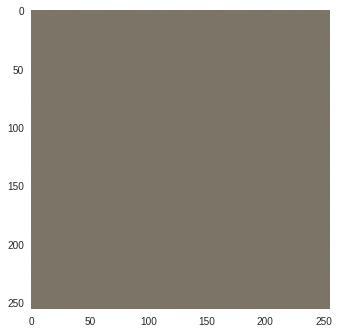

In [65]:
img = plt.imread('./data/out/fur_gram/iter_100_frame_1.png')
plt.imshow(img)
plt.grid(False)